# The FIxed Risk Multicategorical (FIRM) Score
The FIRM score is a verification framework for scoring multicategorical forecasts and warnings (Taggart et al. 2022). The framework is tied to pre-defined risk thresholds (e.g., forecast the highest category for which the probability of observing that category or higher exceeds $X$%). 

FIRM factors in the costs and losses associated with being on the wrong side of a decision threshold, and is therefore aligned to forecast *value* (where a missed event is typically more costly than a false alarm). This is in contrast to most other verification scores for multicategorical forecasts, where the optimal probability/risk threshold depends on the sample climatological frequency. Many of these other verification scores encourage excessive over-forecasting of rare events, causing many false alarms (particularly for longer lead days) and eroding users' confidence in the forecasts.

Lower FIRM scores are better (zero is best).

## How does the FIRM framework work?
A user needs to specify the following:

1. An increasing sequence of category thresholds
2. The weights for the relative importance of each decision threshold 
3. The risk threshold, a value between 0 and 1 that is related to the cost of a miss relative to the cost of a false alarm. Specifically, if the risk threshold is $\alpha$ then the ratio of the cost of a miss relative to the cost of a false alarm is $\alpha/(1-\alpha)$ 
4. Optional: A discount distance parameter, an opportunity to discount the penalty for near misses and near false alarms 

## Example
Let's say that we have a wind warning service that has three categories; nil warning (wind speed < 34 knots), gale warning (34 knots ≤ wind speed < 48 knots), and storm warning (wind speed ≥ 48 knots). This means that our category thresholds are `[34, 48]` where values correspond to wind magnitude forecasts (knots). It's twice as important to get the warning vs nil warning decision threshold correct rather than the gale vs storm warning decision correct, so our weights are `[2, 1]`. 

Next we need to determine our risk threshold. Suppose the ratio between the cost of miss to the cost of false alarm is 3:1. Then $\alpha/(1-\alpha)=3/1$, and so $\alpha = 0.75$. To optimise the expected FIRM score, one must forecast the highest category for which the probability of observing that category or higher has a greater than 25% chance of occurring. This is calculated by $P (event) \ge 1 - \alpha$. In this wind warning service we don't discount the penalty for near misses or near false alarms.

To summarise our FIRM framework parameters:

1. Our category thresholds values are `[34, 48]`
2. Our threshold weights are `[2, 1]`
3. Our risk threshold is `0.75`

Our scoring matrix based on these parameters is

|       | Nil  | Gale | Storm |
|-------|------|------|-------|
| Nil   | 0    | 1.5  | 2.3   |
| Gale  | 0.5  | 0    | 0.75  |
| Storm | 0.75 | 0.25 | 0     |

where the column headers correspond to the observed category and the row headers correspond to the forecast category. For example if the forecast is for storm force winds and gales are observed, then the penalty is 0.25. We can see that:

- There is no penalty along the diagonal if you forecast the correct category.
- You get a bigger penalty for missing an event than for issuing a false alarm. This is due to the risk threshold being set at `0.75`. If the risk threshold $\alpha$ is set to 0.5, then misses and false alarms would receive the same penalty. Alternatively if $\alpha$ is less than 0.5, then you would receive a bigger penalty for producing a false alarm than missing an event. 
- You get twice the penalty for forecasting Nil and observing gales compared to forecasting gales and observing storm force conditions due to the threshold weights. These two penalties sum together when the forecast category differs from the observed category by two categories (i.e., forecasting Nil and observing storm force conditions).

For a detailed explanation of the FIRM calculations and various extensions, please see

Taggart, R., Loveday, N. and Griffiths, D., 2022. A scoring framework for tiered warnings and multicategorical forecasts based on fixed risk measures. *Quarterly Journal of the Royal Meteorological Society*, 148, 1389-1406. [https://doi.org/10.1002/qj.4266](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.4266).

## Python example
Let's verify two synthetic wind warning systems designed for the hypothetical warning service specified above, where the forecast service directive is to forecast the highest category that has at least a 25% chance of occurring. The optimal forecast strategy is to forecast the category in which the 75th percentile forecast lies, or equivalently, forecast the category for which the probability of observing that category or higher is at least 25%. Suppose that we have an ensemble with 100 members that is perfectly calibrated. Warning-System-A forecasts the warning category in which the median value of the ensemble lies. Warning-System-B forecasts the warning category in which the 75th percentile of the ensemble lies.

We assume that our categorical warning service is derived by converting continuous observations and forecasts into our 3 categories. This is handled within the `scores` implementation of `firm`.

In [1]:
import xarray as xr
import numpy as np

from scores.categorical import firm
import matplotlib.pyplot as plt

np.random.seed(100)

In [2]:
ensemble_size = 100
time_len = 10000
background_state = np.random.gamma(7, 2.5, time_len)
uncertainty = 0.75 * np.random.gamma(6, 2, size=(time_len, ensemble_size))
ensemble = background_state[:, np.newaxis] + uncertainty
ensemble = xr.DataArray(
    ensemble,
    dims=["time", "ensemble"],
    coords={"time": np.arange(time_len), "ensemble": np.arange(ensemble_size)},
    name="ensemble",
)
observation = background_state + 0.75 * np.random.gamma(6, 2, size=(time_len))
observation = xr.DataArray(observation, dims=["time"], coords={"time": np.arange(time_len)}, name="observation")

Let's visualise what the ensemble and observations might look like for the first few timesteps. We'll just select some of the percentiles from the ensemble.

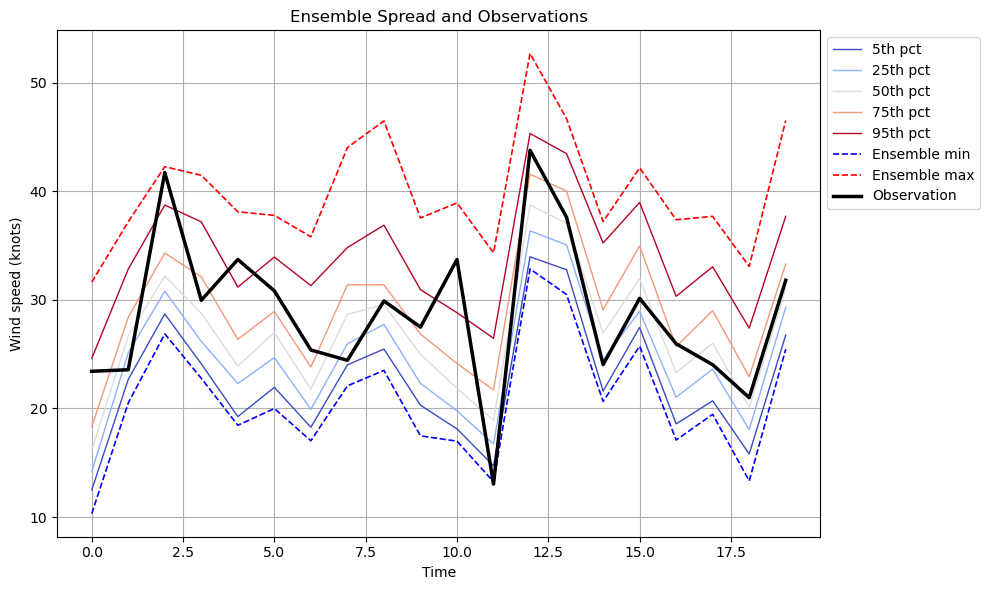

In [ ]:
max_timesteps = 20
ensemble_subset = ensemble.sel(time=slice(0, max_timesteps - 1))
observation_subset = observation.sel(time=slice(0, max_timesteps - 1))

percentiles = np.array([5, 25, 50, 75, 95])
percentile_values = ensemble_subset.quantile(percentiles / 100, dim="ensemble")
ensemble_min = ensemble_subset.min(dim="ensemble")
ensemble_max = ensemble_subset.max(dim="ensemble")

cmap = plt.colormaps.get_cmap("coolwarm")
colors = [cmap(i) for i in np.linspace(0, 1, len(percentiles))]

plt.figure(figsize=(10, 6))

for i, (p, color) in enumerate(zip(percentiles, colors)):
    plt.plot(
        ensemble_subset.time,
        percentile_values[i],
        label=f"{p}th pct",
        color=color,
        linewidth=1,
    )

plt.plot(ensemble_subset.time, ensemble_min, linestyle="--", color="blue", label="Ensemble min", linewidth=1.2)
plt.plot(ensemble_subset.time, ensemble_max, linestyle="--", color="red", label="Ensemble max", linewidth=1.2)
plt.plot(observation_subset.time, observation_subset, color="black", linewidth=2.5, label="Observation")

plt.xlabel("Time")
plt.ylabel("Wind speed (knots)")
plt.title("Ensemble Spread and Observations")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

Let's now derive warnings from Warning-System-A and Warning-System-B using the ensemble

In [4]:
warning_a = ensemble.quantile(0.5, dim="ensemble")
warning_b = ensemble.quantile(0.75, dim="ensemble")

In [ ]:
# Calculate FIRM scores for both warning services
warning_a_firm = firm(
    warning_a,
    observation,
    risk_parameter=0.75,
    categorical_thresholds=[34, 48],
    threshold_weights=[2, 1],
    include_components=True,
)
warning_b_firm = firm(
    warning_b,
    observation,
    risk_parameter=0.75,
    categorical_thresholds=[34, 48],
    threshold_weights=[2, 1],
    include_components=True,
)

In [6]:
# View results Warning-System-A
warning_a_firm.sel(components="firm_score").item()

0.108

In [7]:
# View results Warning-System-B
warning_b_firm.sel(components="firm_score").item()

0.0912

We can see that the FIRM score from Warning-System-B was lower (better) than Warning-System-A. This is because warning-system-B is generated by "forecasting the highest category that has at least a 25% chance of occurring" which aligns with the forecast directive. Although the number of false alarms increased for Warning-System-B, over Warning-System-B the FIRM score was improved by the reduction in (costlier) missed events. 

We can also view the relative contributions to the overall FIRM score from the under-forecast- and over-forecast-penalties.

In [8]:
# We can also view the underforecast and overforecast components of the FIRM score
print(warning_a_firm.sel(components=["underforecast_penalty", "overforecast_penalty"]))

<xarray.DataArray (components: 2)> Size: 16B
array([0.0969, 0.0111])
Coordinates:
    quantile    float64 8B 0.5
  * components  (components) <U21 168B 'underforecast_penalty' 'overforecast_...


In [9]:
# Again, let's look at the underforecast and overforecast components of the FIRM score
print(warning_b_firm.sel(components=["underforecast_penalty", "overforecast_penalty"]))

<xarray.DataArray (components: 2)> Size: 16B
array([0.053925, 0.037275])
Coordinates:
    quantile    float64 8B 0.75
  * components  (components) <U21 168B 'underforecast_penalty' 'overforecast_...


## Further extensions
- Instead of passing in a list of floats for the threshold arg, pass in a list of xr.DataArrays where the thresholds vary spatially and are based on climatological values 
- Test the impact of varying the risk threshold
- Test the impact of the discount distance parameter
- Explore some of the extensions in the [FIRM paper](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.4266)